In [1]:
import numpy as np

def wah_wah_filter(input_signal, sample_rate, min_freq=500, max_freq=3000, lfo_freq=1.0, Q=1):
    """
    Wah-Wah filter implementation.

    Parameters:
        input_signal (numpy array): Input audio signal.
        sample_rate (int): Sampling rate of the signal in Hz.
        min_freq (float): Minimum cutoff frequency of the Wah effect (Hz).
        max_freq (float): Maximum cutoff frequency of the Wah effect (Hz).
        lfo_freq (float): Frequency of the LFO (Hz).
        Q (float): Quality factor of the bandpass filter.

    Returns:
        numpy array: Filtered output signal.
    """
    # Time vector for the input signal
    t = np.arange(len(input_signal)) / sample_rate

    # Generate the LFO (Low-Frequency Oscillator) for modulating the center frequency
    lfo = 0.5 * (1 + np.sin(2 * np.pi * lfo_freq * t))  # Normalized between 0 and 1
    center_freq = min_freq + lfo * (max_freq - min_freq)

    # Initialize filter states
    output_signal = np.zeros_like(input_signal)
    x1, x2, y1, y2 = 0, 0, 0, 0  # Delays for the filter

    for n, sample in enumerate(input_signal):
        # Compute angular frequency and coefficients for the current center frequency
        omega_c = 2 * np.pi * center_freq[n] / sample_rate
        alpha = np.sin(omega_c) / (2 * Q)
        
        b0 = alpha
        b1 = 0
        b2 = -alpha
        a0 = 1 + alpha
        a1 = -2 * np.cos(omega_c)
        a2 = 1 - alpha
        
        # Normalize coefficients
        b0 /= a0
        b1 /= a0
        b2 /= a0
        a1 /= a0
        a2 /= a0

        # Apply the difference equation
        y = b0 * sample + b1 * x1 + b2 * x2 - a1 * y1 - a2 * y2

        # Update delays
        x2 = x1
        x1 = sample
        y2 = y1
        y1 = y

        # Save the output
        output_signal[n] = y

    return output_signal

Wah-Wah filter applied. Filtered audio saved to PinkPanther30_filtered.wav.


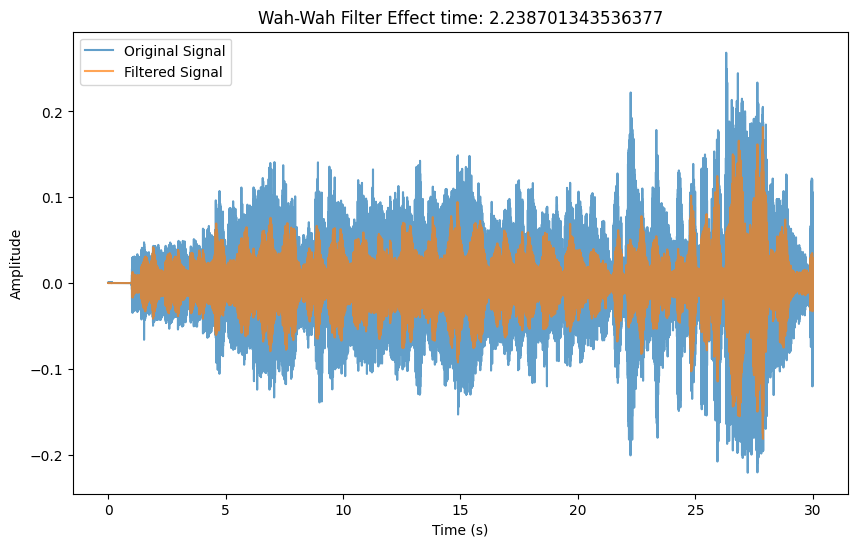

In [3]:
%matplotlib inline

import time
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

# Read input WAV file
input_filename = "PinkPanther30.wav"
output_filename = "PinkPanther30_filtered.wav"
sample_rate, input_signal = wav.read(input_filename)

# Check if the signal is stereo
if len(input_signal.shape) == 2:  # Stereo signal
    input_signal = input_signal.mean(axis=1)  # Convert to mono by averaging channels

# Normalize signal to range [-1, 1] if necessary
if input_signal.dtype == np.int16:
    input_signal = input_signal / 32768.0
elif input_signal.dtype == np.int32:
    input_signal = input_signal / 2147483648.0

# Apply the Wah-Wah filter
start_time = time.time()
filtered_signal = wah_wah_filter(input_signal, sample_rate)
processing_time = time.time() - start_time

# Scale back to int16 for saving
filtered_signal_scaled = np.int16(filtered_signal * 32767)

# Save the filtered signal to a new WAV file
wav.write(output_filename, sample_rate, filtered_signal_scaled)

print(f"Wah-Wah filter applied. Filtered audio saved to {output_filename}.")

# Plot the original and filtered signals
t = np.arange(len(input_signal)) / sample_rate
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label="Original Signal", alpha=0.7)
plt.plot(t, filtered_signal, label="Filtered Signal", alpha=0.7)  # Scale back for plotting
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Wah-Wah Filter Effect time: {processing_time}")
plt.legend()
plt.show()